In [238]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import math
import matplotlib.colors as mcolors


class Point:
    """
    Create a point in space."""
    def __init__(self,x,y, identifier, mass=1.0,vx=0,vy=0, acc_x=0, acc_y=0, color=None):
        """
        Each point will have:
        mass (default 1.0),
        vx = velocity x_component (default = 0),
        vy = velocity y_component (default = 0),
        acc_x = acceleration x_component (default = 0),
        acc_y = acceleration y_component (default = 0)"""
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.identifier = identifier
        self.color = color
    
    def update_position(self, quadtree,dt):
        """Updates the position of the point based 
        on the Barnes-Hut algorithm
        quadtree = Quadtree object,
        dt = unit time
        """
        
        # Calculate the net force on the point
        force_x, force_y = quadtree.calculate_force(self)
        # Update the position
        self.vx += force_x / self.mass
        self.vy += force_y / self.mass
        self.x += self.vx*dt
        self.y += self.vy*dt
        
    def find_stable_orbital_velocity(self, central_point, g_const):
        """
        Find the stable orbital velocity for the point
        ***
        central_point must be a point object!
        ***
        """
        G = g_const
        r = math.sqrt(((self.x-central_point.x) ** 2) + ((self.y-central_point.y) ** 2)) # distance between the point and central mass
        velocity = math.sqrt((G * central_point.mass) / r)
        omega = -velocity/r
        # 
        self.vx =-omega * (r *(math.sin(omega)))
        self.vy =omega * (r *(math.cos(omega)))
        
        
class Rectangle:
    def __init__(self,x,y,w,h):
        """
        x = center of the Rectangle
        y = center of the Rectangle
        w = width of the rectangle
        h = height of the rectangle
        """
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y+h/2, y-h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y <= self.north_edge and point.y >= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='red'):
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c=color, lw=1)
        
        

class Quadtree:

    def __init__(self,boundary, G,theta_, n = 1):
        """
        Creates a Quadtree:
        boundary: Rectangle instance
        n = capacity
            choosing n = 1, i.e. if particle number crosses 1 than sub-divide
        G = gravitational constant
        theta_ = barnes hut algo theta (default value = 1)
        """
        self.boundary = boundary

        # choosing capacity(n) = 1, i.e. if particle number crosses 1 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []
        self.quads = [None, None, None, None]
        self.divided = False
        self.mass = 0.0
        self.G = G
        self.theta_ = theta_
        self.center_of_mass_x = 0.0
        self.center_of_mass_y = 0.0

    def subdivide(self):
        """
        Subdivides the region into four parts
               1  |  2
             ____ |____
                  |
               3  |  4
               
               quad[0] = 1st quadrant (north west)
               quad[1] = 2nd quadrant (north east)
               quad[2] = 3rd quadrant (south west)
               quad[3] = 4th quadrant (south east)
        """
        #print("Subdividing region: ", self.boundary.x, self.boundary.y, self.boundary.w, self.boundary.h)
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2, y + h/2, w, h)
        self.quads[1] = Quadtree(ne, G= self.G, theta_=self.theta_, n=self.capacity)
        nw = Rectangle(x - w/2, y + h/2, w, h)
        self.quads[0] = Quadtree(nw, G= self.G, theta_=self.theta_, n=self.capacity)
        se = Rectangle(x + w/2, y - h/2, w, h)
        self.quads[3] = Quadtree(se, G= self.G, theta_=self.theta_, n=self.capacity)
        sw = Rectangle(x - w/2, y - h/2, w, h)
        self.quads[2] = Quadtree(sw, G= self.G, theta_=self.theta_, n=self.capacity)

        self.divided = True
        
        # Check if existing points contain in children:
        for point in self.points:
            for quad in self.quads:
                quad.insert(point)
                
    def exist(self, point):
        """
        Checks is a given point already exists in the quadtree:
         returns : True or False
        """
        if point in self.points:
            print('point does exist')
            return True
        return False

    def limit_reached(self):
        """
        Checks the recursive limit and returns Boolean value
        
        Returns: False (if limit not reached)
        Returns: True (if limit reached (stop adding points))
        """
        threshold = 0.1
        
        if self.boundary.w < threshold:
            return True
        
        return False
        
    def insert(self, point):
        """
        Insert a point in the quadtree.
        
        Updates the mass and center of mass for each of the """
        if self.divided:
            for quad in self.quads:
                if quad.insert(point):
                    self.points.append(point)
                    self.mass = sum([p.mass for p in self.points])
                    self.center_of_mass_x = sum([p.mass*p.x for p in self.points])
                    self.center_of_mass_y = sum([p.mass*p.y for p in self.points])
                    return True

        # Check if the point is in Boundary
        if self.boundary.contains(point):

            # set recursive limit
            threshold = 0.1
            if len(self.points) < self.capacity and not self.limit_reached():
                self.points.append(point)
                self.mass = point.mass
                self.center_of_mass_x = point.x*point.mass
                self.center_of_mass_y = point.y*point.mass
                return True

            self.points.append(point)
            self.mass = sum([p.mass for p in self.points])
            self.center_of_mass_x = sum([p.mass*p.x for p in self.points])
            self.center_of_mass_y = sum([p.mass*p.y for p in self.points])

            if not self.divided and not self.limit_reached():
                self.subdivide()
                for quad in self.quads:
                    if len(quad.points) == 0:
                        quad.insert(point)
                        return True
        else:
            return False

        
    def center_of_mass(self):
        """
        Returns (X, Y) for COM
        """
        return self.center_of_mass_x/self.mass, self.center_of_mass_y/self.mass
    
    
    
    def calculate_force(self, point):
        """Calculates the net force on the point"""
        if self.mass == 0:
            return 0, 0
        if not self.divided:
            return self._calculate_force_on_point(point)
        else:
            if self._should_use_approximation(point):
                return self._calculate_force_on_point_approximation(point)
            else:
                force_x, force_y = 0, 0
                for quad in self.quads:
                    fx, fy = quad.calculate_force(point)
                    force_x += fx
                    force_y += fy
                return force_x, force_y

    def _calculate_force_on_point(self, point):
        """Calculates the force on the point due to all other points in the quadtree"""
        #print(f"point force calc")
        force_x, force_y = 0, 0
        for other_point in self.points:
            if other_point != point:
                dx = other_point.x - point.x
                dy = other_point.y - point.y
                r = (dx ** 2 + dy ** 2) ** 0.5
                if r == 0:
                    continue
                force = self.G * point.mass * other_point.mass / (r ** 2)
                force_x += force * dx / r
                force_y += force * dy / r
        return force_x, force_y
    
    def _calculate_force_on_point_approximation(self, point):
        """Calculates the force on the point due to the center of mass of the quadtree"""
        com_x,com_y = self.center_of_mass()
        dx = com_x - point.x
        dy = com_y - point.y
        r = (dx ** 2 + dy ** 2) ** 0.5
        if r == 0:
            return 0, 0
        force = self.G * point.mass * self.mass / (r ** 2)
        return force * dx / r, force * dy / r
    
    def _should_use_approximation(self, point):
        com_x, com_y = self.center_of_mass()
        """Determines whether to use the approximation or not"""
        r = ((point.x - com_x)**2 + (point.y - com_y)**2)**0.5
        return self.boundary.w / r < self.theta_


    def clear(self):
        """
        Clears the quadtree by resetting all points and sub-quadrants
        """
        self.points = []
        self.mass = 0.0
        self.center_of_mass_x = 0
        self.center_of_mass_y = 0
        self.divided = False
        self.quads = [None, None, None, None]
        
    def show(self, axis=None):
        """
        Shows the quadtree
        
        Will use plt.gca() if no axis is given."""
        if axis == None:
            self.boundary.show(plt.gca())
        else:
            self.boundary.show(axis)
        
        if self.divided:
            for quad in self.quads:
                quad.show(axis)

    
    def show_from_point(self, point,axis=None, color='red'):
        """Shows the quadtree w.r.t given point. Uses Barnes Hut algorithm.
        
        """
        rect = self.boundary
        
        # Get the current axis
        if axis == None:
            axis = plt.gca()
        
        # Find the point
        for self_point in self.points:
            if point.identifier == self_point.identifier:
                # point of interest
                poi = self_point
        
        x, y = poi.x, poi.y
        com_x,com_y = self.center_of_mass()
        
        distance = math.sqrt(((com_x - x) ** 2) + ((com_y - y) ** 2)) + 1e-9
        ratio = max(rect.w, rect.h) / distance
        
        # Barnes-Hut condition:
        if ratio < self.theta_:
            rect.boundary.show(axis)
        else:
            if self.divided:
                for quad in self.quads:
                    quad.show(axis)

In [239]:
class BarnesHutAlg():
    """
    Runs Barnes-Hut Algorithm on given points.
    
    Inputs : points, kwargs
    
    **kwargs:
    
            `wrap`: boolean (True or False)
                It will wrap the points such that
                they won't leave the parent boundary.
                
            `save_to_video:` boolean (True or False)
                Save the video in MP4 format
                **Note**: uses 
    """
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def process_kwargs(self, **kwargs):
        for key, value in kwargs.items():
            
            # Wrap the points
            if key == "wrap":
                if value == True:
                    self.wrap(self.points)
            
            #
            elif key == "subtract":
                result = self.subtract(value)
            else:
                result = "Invalid operation"
            print(f"{key}: {result}")
    

In [240]:
def get_cart_coords(r,theta):
    """returns x,y"""
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy

In [241]:
def barnes_hut_sim(points, _wrap_points=False,
                   dt=1, g_const=0, theta=1,
                   save_to_video = False,
                   show_quadtree=False, show_quadtree_wrt_point = None,
                  n_frames=50):
    """
    Output: Refreshing plot of points being simulated using Barnes-Hut Algorithm.
    
    points = A list of "Point class" objects.
    
    _wrap_points = Wraps the points if they go out of bound.
    
    
    """
    
    def wrap_point(p):
        """
        Wraps the points such that they don't leave the boundary.
        """
        # wrap around when the particle goes out of bounds
        if p.x > width:
            p.x -= width
        elif p.x < 0:
            p.x += width
        if p.y > height:
            p.y -= height
        elif p.y < 0:
            p.y += height
    
    # initialize the quadtree and the points list
    qt = Quadtree(boundary,n=1, G=g_const, theta_=theta)
    for p in points:
        qt.insert(p)

    # for saving video
    frames = []
    
    # in the main loop
    for time in range(n_frames):
        fig, ax = plt.subplots(figsize=(10,10))
        # Plot stars list
        ps = []
        
        # Clear all the points in the tree:
        qt.clear()
        # clear the quadtree before inserting the new positions of the points
        
        for p in points:

            # wrap around when the particle goes out of bounds
            if _wrap_points:
                wrap_point(p)

            # update the position of the point using the Barnes-Hut algorithm
            p.update_position(qt,dt=dt)

            # insert the updated position of the point into the quadtree
            qt.insert(p)
            
            # add stars for plotting
            ps.append([p.x,p.y])
        
        ps = np.array(ps)
        
        
        
        
        # Plot points/stars
        ax.scatter(ps[:,0],ps[:,1],s=10,alpha=0.5,c='black')
        
        #######
        #ax.hist2d(ps[:,0],ps[:,1],bins=100, range=[[-width*0.1, width*1.1],[-height*0.1, height*1.1]])
        #######
        
        ax.set_xlim(-width*0.1, width*1.1)
        ax.set_ylim(-height*0.1, height*1.1)
        # Show the Quadtree
        if show_quadtree:
            # Show the quadtree
            qt.show(ax)
        # Show quadtree wrt point
        if show_quadtree_wrt_point is not None:
            qt.show_from_point(show_quadtree_wrt_point,ax)
        # Convert the figure to a numpy array
        if save_to_video:
            fig.canvas.draw()
            data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(data)
            
       
        plt.show()
        print(f"frame: {time}/{n_frames}")  
        clear_output(wait=True)
    if save_to_video:
        import imageio     
        imageio.mimsave(save_to_video, frames, 'MP4', fps=30)

# Debuggin the code:



In [242]:
qt = Quadtree(Rectangle(30,30,60,60), G=1,theta_=1,n=1)

Inserting the points in the quad tree:

In [243]:
p1 = Point(x=24,y=8, identifier=1, mass=10)
p2 = Point(x=36,y=12, identifier=2, mass=11)
p3 = Point(x=42,y=16, identifier=3, mass=12)
p4 = Point(x=12,y=19, identifier=4, mass=13)
p5 = Point(x=12,y=10, identifier=5, mass=14)

In [244]:
points = [p1,p2,p3,p4,p5]

In [245]:
points_random = [Point(x=np.random.uniform(0,60),
                       y=np.random.uniform(0,60),
                       identifier=np.random.randint(1,100),
                      mass = np.random.uniform(1,100)) for i in range(102)]

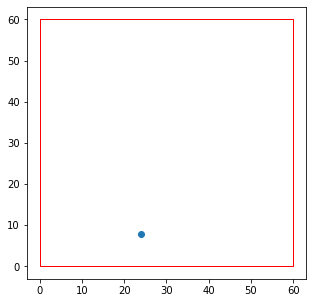

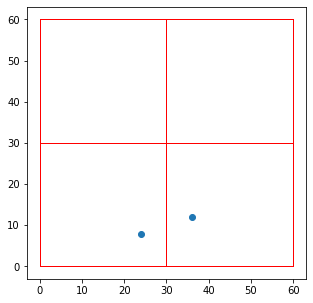

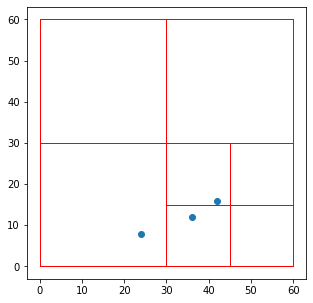

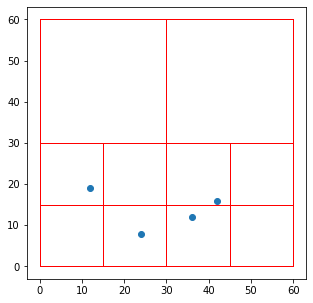

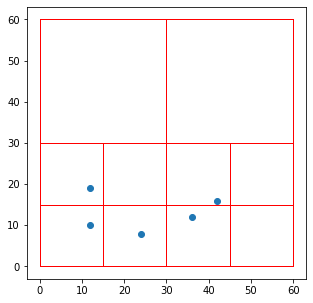

In [246]:
qt.clear()
x_list = []
y_list = []
for point in points:
    print(point)
    plt.figure(figsize=(5,5))
    x_list.append(point.x)
    y_list.append(point.y)
    qt.insert(point)
    plt.scatter(x_list,y_list)
    qt.show()
    plt.show()


## We can do all things at once:

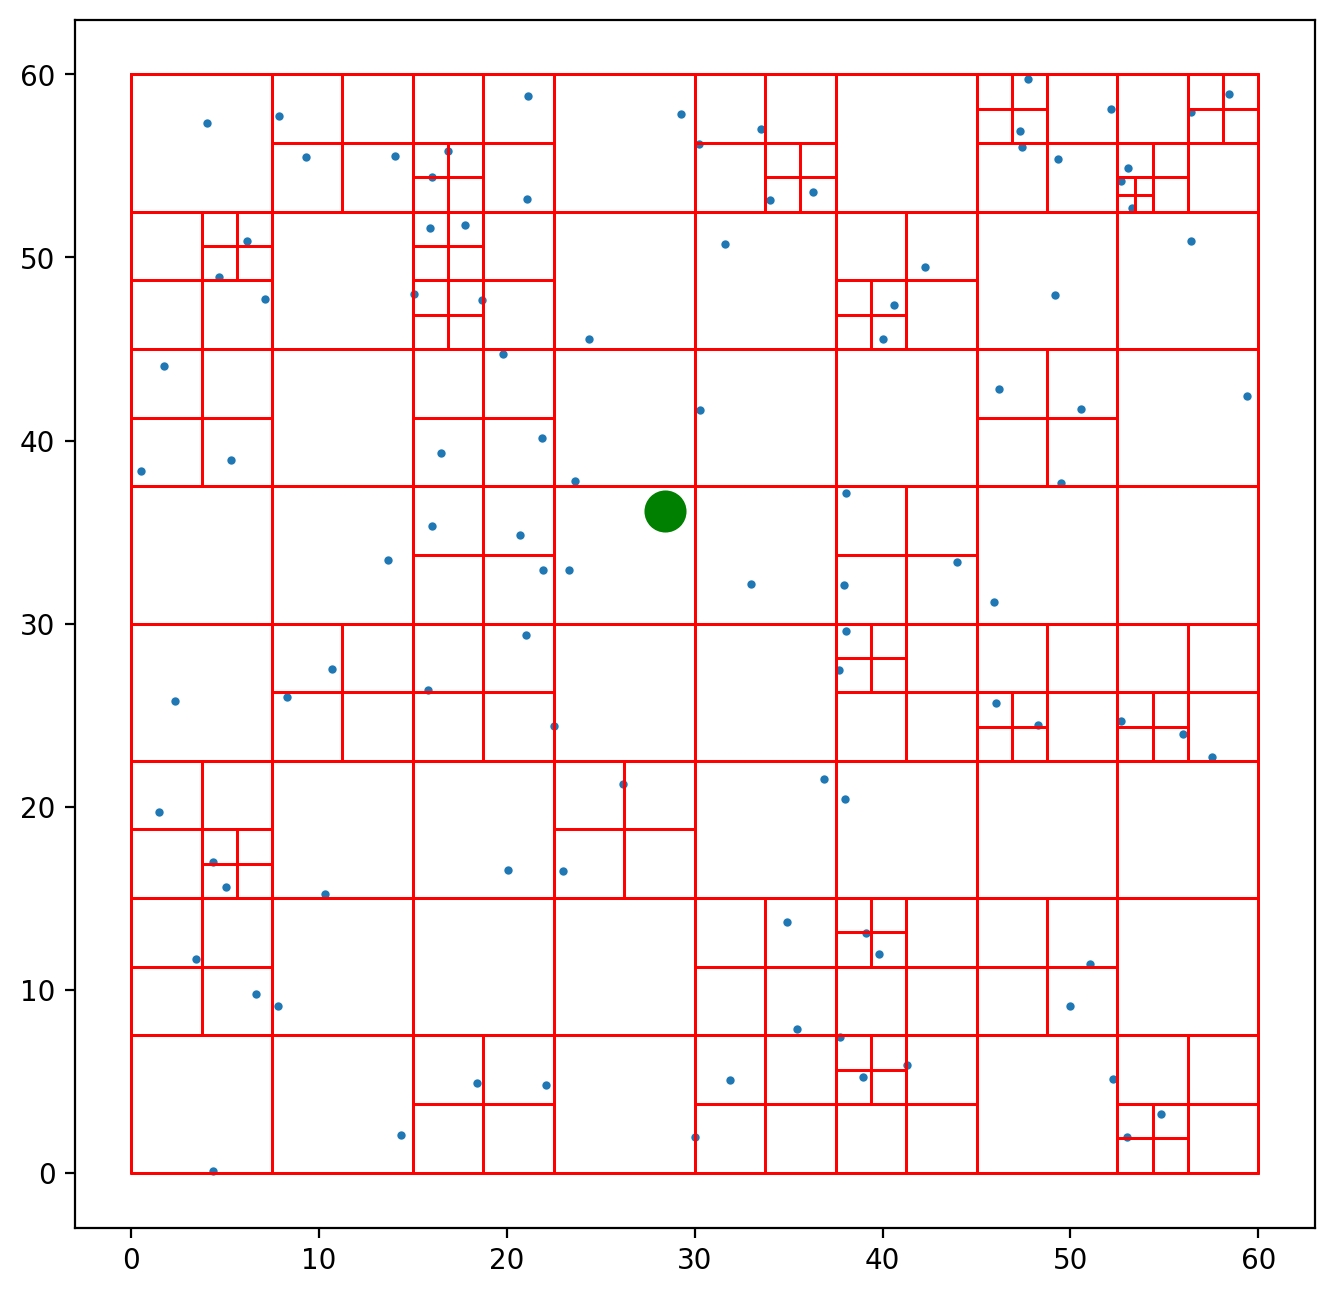

In [247]:
p_list = points_random
qt.clear()
for p in p_list:
    qt.insert(p)
    
plt.figure(figsize=(8,8),dpi=200)
plt.scatter([p.x for p in p_list], [p.y for p in p_list],s=4)
# Center of mass for the entire quadrant:
plt.scatter(qt.center_of_mass_x/qt.mass, qt.center_of_mass_y/qt.mass, s=200, c='green')
qt.show()
plt.show()

11

In [295]:
sum([qt.quads[2].points])

In [263]:
sum([p.mass for p in points_random])

869.4014504505911

In [216]:
qt.mass

58.88688849071703

In [264]:
qt.points

In [292]:
len(qt.points)

60

It is giving me an empty list. It should be the same as `points` variable:

In [625]:
points

Checking `insert()` in `Quadtree` class.

In [155]:
qt.mass

60

# Galaxy with stable orbit for stars

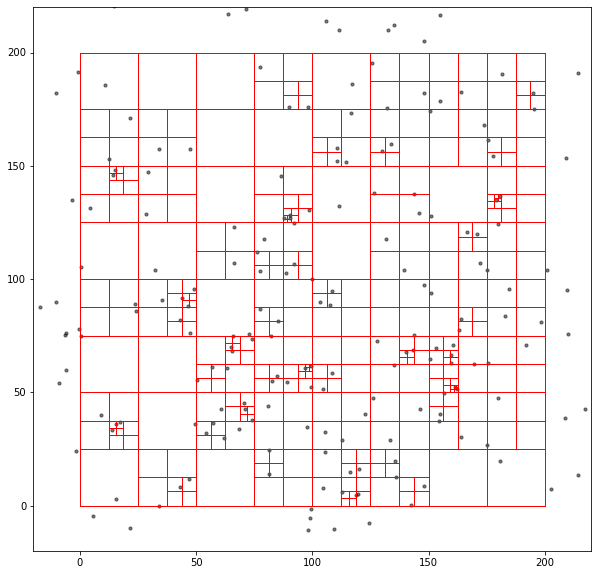

frame: 499/500


In [249]:
# Rectangle (boundary) specs
width = 200
height = 200
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x-0.01,center_y-0.01,width,height)


# New points
points = []

black_hole_point = Point(center_x,center_y, identifier=1, mass= 900,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

# Assign stars to this galaxy with random mass:
for i in range(400):
    point = Point(x=np.random.normal(points[0].x,100) , y=np.random.normal(points[0].y, 100),
                        mass=np.random.uniform(98,100),
                        identifier=i+2)
    
    # Find the stable orbital velocity and update the 
    point.find_stable_orbital_velocity(central_point=black_hole_point,
                                      g_const=0.01)
    points.append(point)
    
barnes_hut_sim(points,show_quadtree=False,
               g_const=0.01,dt=0.1,theta=1,
               show_quadtree_wrt_point=black_hole_point,
               save_to_video='stable_orbit_trial1_heatmap.mp4',
               n_frames=500)

## Second Sample:

number of points: [<__main__.Point object at 0x00000239EB93A370>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of 

number of points: [<__main__.Point object at 0x00000239819960D0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 3.813334135899561e+58
force due to approximate calc = 9.015803839878827e-88
Approximate calculation for quad with center at 1000.0
 and COM_x at 4.677438597276871e+58
force due to approximate calc = 4.8240136682664975e-88
number of points: [<__main__.Point object at 0x00000239EB93A0A0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 9.765512434770169e+58
force due to approximate calc = 2.036568497119122e-88
number of points: [<__main__.Point object at 0x00000239EB93A0D0>]
number of points: [<__main__.Point object at 0x00000239EB93A0D0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.445897950126835e+59
force due to approximate calc = 1.0928153116575258e-89
number of points: [<__main__.Point object at 0x00000239EB93A1F0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 4.638196301820294e+

number of points: [<__main__.Point object at 0x00000239EB93D640>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 1.3398720476060153e+84
force due to approximate calc = 1.6786069736280365e-122
number of points: [<__main__.Point object at 0x00000239EB742430>]
number of points: [<__main__.Point object at 0x00000239EB742430>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 1.3619531323283295e+84
force due to approximate calc = 9.9865380419906e-123
number of points: [<__main__.Point object at 0x00000239EB92D610>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 1.397151536075893e+84
force due to approximate calc = 2.0142203382035675e-122
number of points: [<__main__.Point object at 0x00000239EB750370>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 1.452680565098621e+84
force due to approximate calc = 1.1893810506469968e-122
number of points: [<__main__.Point object at 0x00000239EB92D610>]
number of points:

<ipython-input-606-43e873e83401>:91: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


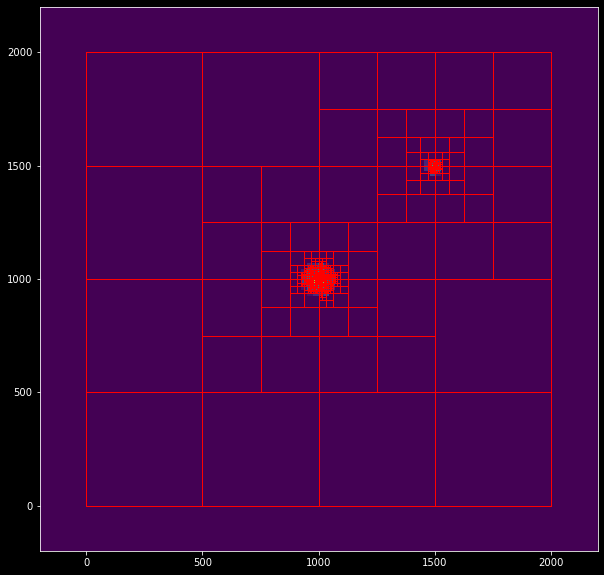

frame: 0/50
point force calc
number of points: [<__main__.Point object at 0x00000239EB93A370>]
number of points: [<__main__.Point object at 0x00000239EB93A2E0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 1182891380169.8376
force due to approximate calc = 2.3295987078512277e-11
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
number of points: [<__main__.Point object at 0x00000239EB93A130>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 2365782760339.6753
force due to approximate calc = 5.1718781611762345e-11
number of points: [<__main__.Point object at 0x00000239EB93A130>]
Approximate calculation f

 and COM_x at 5.76085867766087e+80
force due to approximate calc = 2.494938996989074e-118
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.761165800509351e+80
force due to approximate calc = 3.928997024912707e-118
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.761717102704316e+80
force due to approximate calc = 9.523220673765704e-118
number of points: [<__main__.Point object at 0x00000239EB9254F0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.762695841786129e+80
force due to approximate calc = 6.0017257202388915e-118
number of points: [<__main__.Point object at 0x00000239EB93D5E0>]
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.764412031894588e+80
force due to approximate calc = 8.1874102090624e-118
Approximate calculation for quad with center at 1000.0
 and COM_x at 5.767383641646665e+80
force due to approximate calc = 7.726580297637382e-118
number of points: [<__main__.Point object at 0x00

KeyboardInterrupt: 

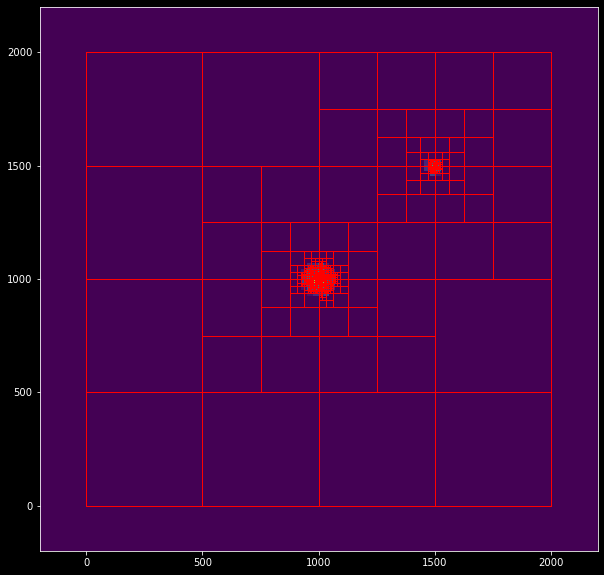

In [608]:
# specs of Rectangle (the main boundary):
width = 2000
height = 2000
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x,center_y,width,height)

# New points
points = []

black_hole_point = Point(center_x-0.01,center_y-0.01, identifier=1, mass= 5000,vx=0,vy=0)
# black hole at center
points.append(black_hole_point)

# rogue: black hole:
rogue_x = center_x + width*0.25
rogue_y = center_y + height*0.25
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,identifier= 2, mass=3500,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(100):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-10,0)
    thetav = np.random.normal(loc=-40,scale=1) if abs(x) <3 and abs(y) <3 else np.random.normal(-1,1)
    vx,vy = get_cart_coords_vel(0,0,r,theta)
    
    mass = np.random.randint(300,1000)
    points.append(Point(x+rogue_x,y+rogue_y, identifier=i+3,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(500):
    r = np.random.uniform(1,70)
    theta = i*360/80
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-100,-90)
    thetav =-350 if abs(x) <30 and abs(y) <30 else -10
    #thetav = 0
    rv= -10
    vx,vy = get_cart_coords_vel(0,0,r,theta)
    
    mass = np.random.randint(200,2000)
    
    thetav = np.sqrt(150/r)
    points.append(Point(x+center_x,y+center_y,identifier=i+503, # 200 is the number of stars in rogue black hold
                        mass=mass,vx=vx,vy=vy))

    
##############
#####RUNNING THE SIMULATION #########################
barnes_hut_sim(points,
               dt=0.01,
               g_const=100,
               theta=0.3,
               _wrap_points=False,
               save_to_video='barnes_hut_1.mp4',
               show_quadtree_wrt_point=points[0])

In [561]:
len(points)

1001

In [565]:
for point in points:
    print(point)
    qt.insert(point)

number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x000002398042A0D0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x00000239806787F0>]
number of points: [<__main__.Point object at 0x0000023980680820>]
number of points: [<__main__.Point object at 0x0000023980680820>]
number of 

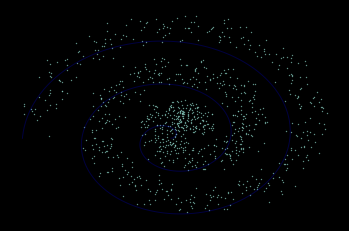

In [152]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')  
fig, ax = plt.subplots()

# Generate x and y coordinates for the spiral pattern
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

# Plot the spiral pattern
ax.plot(x,y,color='blue',linewidth=1,alpha=0.25)
ax.scatter(x_init, y_init, s=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()

<ipython-input-62-f7ca8dd2858f>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


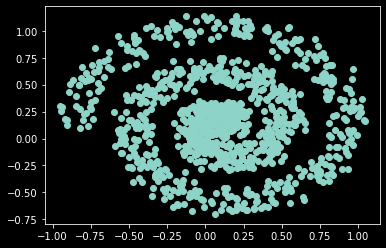

In [62]:
fig, ax = plt.subplots()
ax.scatter(x_init, y_init)

# Convert the figure to a numpy array
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [65]:
data.shape

(288, 432, 3)